# Synthetic Sonic Log Generation

* __Authors__: Team - '**Oilers**' (Shreshth Srivastav, Khushal Adlakha, Choukha Ram )
* __Date__: April 30th, 2020

- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
- <a>2. Imports</a>
- <a>3. Data Exploration & Preparation</a>
- <a>4. Build Machine Learning Models</a>
- <a>5. Model Predictions and Performance on Small Test Data</a>
- <a>6. Predictions on Test data</a>
- <a>7. Summary </a>


## <a>1. Introduction: Synthetic Sonic Curves Generation</a>¨
Introduction Section, taken as it is from the [Starter Notebook](https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb)


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt;**train.csv**
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt;**test.csv**
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt;**sample_submission.csv**
A valid sample submission.

&gt;**real_result_20perc.csv**
A blind test dataset from 20% of the hidden dataset is released for the your judgement, you may check your model performance based on this dataset as many times as you want.

Please note that the purpose of the released dataset is providing a validation tool to check the performance of your model. However, in the real application there would be no such data, since we will not have any access to the new well's data. Therefore please do not use the data to train your model.


<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

In [0]:
# import libraries
# For Suppressing Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# general
import pandas as pd
import numpy as np
# Plotting Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn libararies
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
# ML Model
import xgboost as xgb
# For Automatic EDA
#from pandas_profiling import ProfileReport

## <a>3. Data Exploration & Preparation</a>

### <a>3.1 Download the data from Github</a>

In [2]:
! mkdir data
! wget -P data https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Data3_1_2020.zip?raw=true
! unzip data/Data3_1_2020.zip?raw=true -d data
! rm data/Data3_1_2020.zip?raw=true

--2020-05-08 03:33:10--  https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Data3_1_2020.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip [following]
--2020-05-08 03:33:10--  https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pddasig/Machine-Learning-Competition-2020/master/Data3_1_2020.zip [following]
--2020-05-08 03:33:10--  https://raw.githubusercontent.com/pddasig/Machine-Learning-Competition-2020/master/Data3_1_2020.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.

In [3]:
! ls data

sample_submission.csv  test.csv  train.csv


In [4]:
# We also need to download the blind test dataset from 20% of the hidden dataset, which we received over the email and then uploaded to github
! wget https://raw.githubusercontent.com/choukha/pddata/master/real_result_20perc.csv

--2020-05-08 03:37:09--  https://raw.githubusercontent.com/choukha/pddata/master/real_result_20perc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148252 (145K) [text/plain]
Saving to: ‘real_result_20perc.csv’

real_result_20perc. 100%[===================>] 144.78K  --.-KB/s    in 0.03s   

2020-05-08 03:37:10 (4.19 MB/s) - ‘real_result_20perc.csv’ saved [148252/148252]



### <a>3.2 Read the data</a>

In [0]:
# Training Data
df = pd.read_csv('data/train.csv')

In [0]:
# Small Test Dataset ( 20% )
dt = pd.read_csv('real_result_20perc.csv')

In [0]:
# TEST FILE
test = pd.read_csv("data/test.csv")

### <a>3.3 Basic stats and plots </a>

In [0]:
print(df.shape,dt.shape,test.shape)

(30143, 9) (2217, 9) (11088, 7)


In [0]:
df.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS'], dtype='object')

In [0]:
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [0]:
test.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


Test Data seems quite different from the Train Data. We also checked for the covariate shift between these two datasets and found that both the datasets are different due to different distributions of CAL, PE and others. Information from covariate shift can be utilized to select the features or giving weights to training instances.

In [0]:
# For convenience, let's copy the Raw Training data into another dataframe to further work and modify
df1 = df.copy()

In [0]:
# Replace value -999 ( missing value indicators ) as NA
df1.replace(['-999', -999], np.nan, inplace=True)

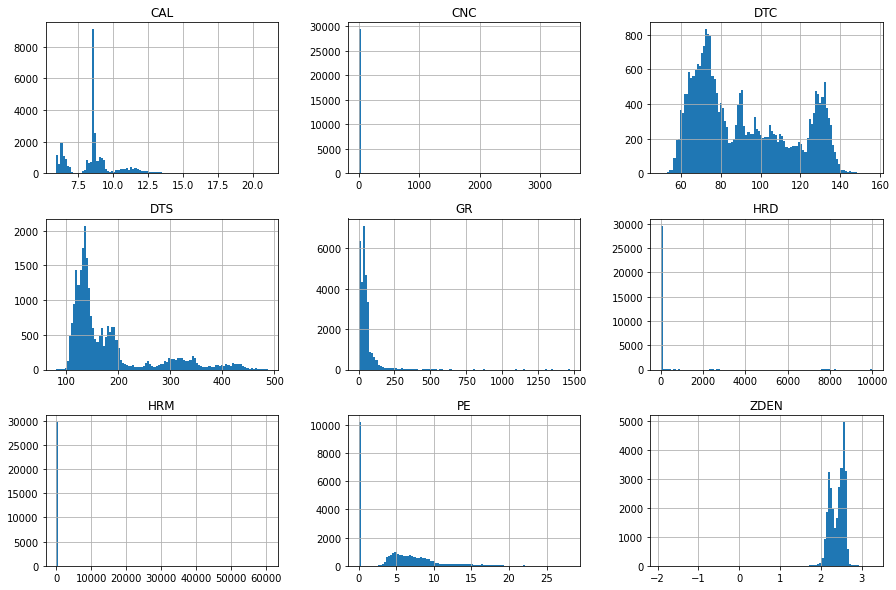

In [0]:
histdf = df1.hist(bins=100,figsize=(15,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37fa2d90b8>,
      dtype=object)

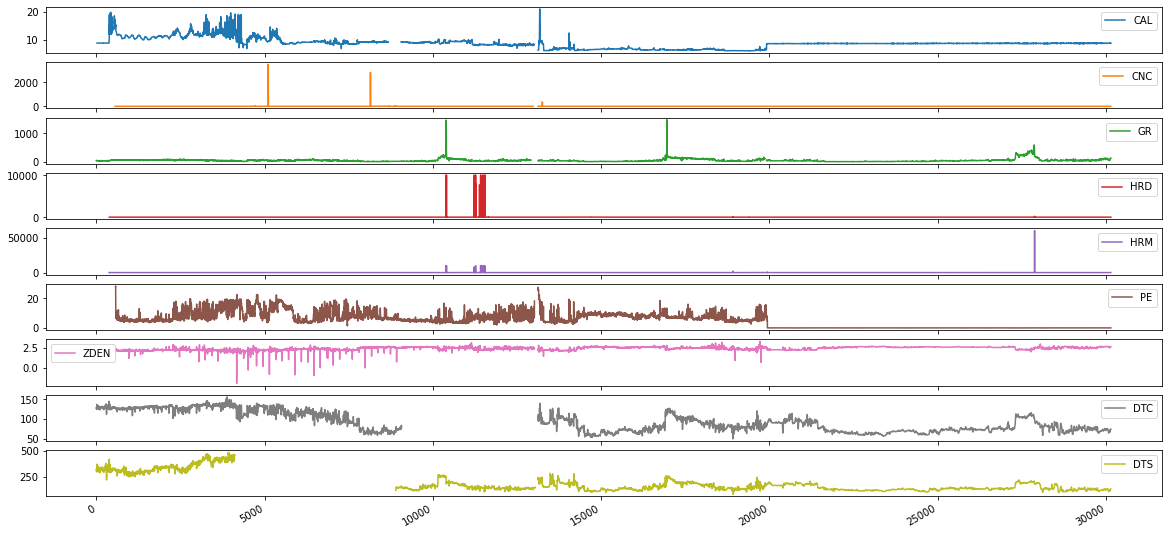

In [0]:
df1.plot(subplots=True,figsize=(20,10))

### <a>3.4 Nullify the Negative Values</a>

In [0]:
df1['ZDEN'][df1['ZDEN']<0] = np.nan
df1['GR'][df1['GR']<0] = np.nan
df1['CNC'][df1['CNC']<0] = np.nan
df1['PE'][df1['PE']<0] = np.nan

### <a>3.4 Nullify the Extreme Values or Outliers</a>
Outlier limits and ranges are identified based on the stats from Train and Test data. Instead of dropping the rows with such values, we replace them with NaNs

In [0]:
# GR
df1['GR'][(df1['GR']>250)] = np.nan
# CNC
df1['CNC'][df1['CNC']>0.7] = np.nan
# HRM & HRD
df1['HRD'][df1['HRD']>200] = np.nan
df1['HRM'][df1['HRM']>200] = np.nan

### <a>3.5 Log Transformation on skewed variables </a>
HRD and HRM variables are quite skewed, hence we need to transform them.

In [0]:
df1['HRM'] = df1['HRM'].apply(lambda x:np.log(x))
df1['HRD'] = df1['HRD'].apply(lambda x:np.log(x))

In [0]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,29633.000000,29195.000000,29513.000000,29683.000000,29687.000000,29455.000000,29454.000000,26089.000000,25278.000000
mean,8.654281,0.245114,44.140058,0.475938,0.490181,5.174812,2.394661,91.814381,180.655730
std,1.749145,0.152072,36.486081,0.977667,0.988046,4.780959,0.189292,24.337910,81.141960
min,5.930400,0.004100,0.000000,-2.916921,-2.787093,0.000000,0.003500,49.970500,80.580400
25%,8.135600,0.126600,17.682600,-0.303066,-0.309723,0.054200,2.234900,71.357000,129.446625
50%,8.625000,0.197300,36.719400,0.503861,0.505914,5.043800,2.439700,85.237600,144.593050
75%,9.063000,0.337900,57.633200,1.153542,1.191723,7.950150,2.553100,112.112600,191.475125
max,21.064200,0.699600,249.904800,5.292286,5.287507,28.106400,3.259700,155.980300,487.438400


### <a>3.6 Correlations</a>

In [0]:
df1.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,0.582005,0.040421,-0.199495,-0.164176,0.163877,-0.368183,0.585637,0.681271
CNC,0.582005,1.000000,0.486927,-0.526469,-0.531618,0.437687,-0.698973,0.943968,0.898753
GR,0.040421,0.486927,1.000000,-0.104434,-0.111190,0.031718,-0.178068,0.427692,0.308994
HRD,-0.199495,-0.526469,-0.104434,1.000000,0.981400,-0.245251,0.622416,-0.608752,-0.436526
HRM,-0.164176,-0.531618,-0.111190,0.981400,1.000000,-0.279317,0.622436,-0.605481,-0.435709
PE,0.163877,0.437687,0.031718,-0.245251,-0.279317,1.000000,-0.340607,0.477524,0.440266
ZDEN,-0.368183,-0.698973,-0.178068,0.622416,0.622436,-0.340607,1.000000,-0.756792,-0.670186
DTC,0.585637,0.943968,0.427692,-0.608752,-0.605481,0.477524,-0.756792,1.000000,0.941639
DTS,0.681271,0.898753,0.308994,-0.436526,-0.435709,0.440266,-0.670186,0.941639,1.000000


In [0]:
test.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
CAL,1.000000,-0.290943,0.024399,0.037764,0.050929,0.446757,0.438947
CNC,-0.290943,1.000000,0.575440,-0.247362,0.016520,-0.563464,-0.710657
GR,0.024399,0.575440,1.000000,-0.124756,0.154772,-0.121305,-0.129897
HRD,0.037764,-0.247362,-0.124756,1.000000,0.415450,-0.002108,0.077118
HRM,0.050929,0.016520,0.154772,0.415450,1.000000,0.046397,0.028714
PE,0.446757,-0.563464,-0.121305,-0.002108,0.046397,1.000000,0.870180
ZDEN,0.438947,-0.710657,-0.129897,0.077118,0.028714,0.870180,1.000000


In [0]:
dt.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,-0.272537,0.045407,0.034635,0.060653,0.459406,0.440301,-0.320136,-0.410835
CNC,-0.272537,1.000000,0.548729,-0.209147,-0.015163,-0.532309,-0.680442,0.932308,0.839232
GR,0.045407,0.548729,1.000000,-0.102104,0.038432,-0.026737,-0.057722,0.466689,0.348867
HRD,0.034635,-0.209147,-0.102104,1.000000,0.528032,-0.028078,0.047874,-0.161745,-0.209074
HRM,0.060653,-0.015163,0.038432,0.528032,1.000000,0.051307,0.036016,-0.010130,-0.026211
PE,0.459406,-0.532309,-0.026737,-0.028078,0.051307,1.000000,0.873218,-0.684861,-0.499729
ZDEN,0.440301,-0.680442,-0.057722,0.047874,0.036016,0.873218,1.000000,-0.786119,-0.644818
DTC,-0.320136,0.932308,0.466689,-0.161745,-0.010130,-0.684861,-0.786119,1.000000,0.814091
DTS,-0.410835,0.839232,0.348867,-0.209074,-0.026211,-0.499729,-0.644818,0.814091,1.000000


### <a>3.7 Predictive Power Score (PPS)</a>
The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

  Created wheel for ppscore: filename=ppscore-0.0.2-py2.py3-none-any.whl size=9629 sha256=2b41b5e025cbba47a347dddf418785345879dce4deb2898fc71c9a5a1a596a82
  Stored in directory: /root/.cache/pip/wheels/29/32/a2/82782fc09f5cd68e401ff047201d38af8965fb94984db18aa5
Successfully built ppscore


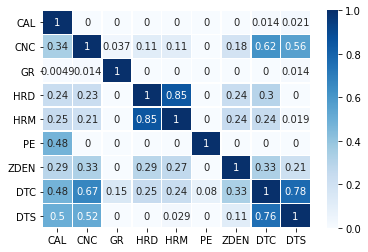

In [0]:
! pip install ppscore
import ppscore as pps
df_matrix = pps.matrix(df1)
sns.heatmap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## <a>4. Build Machine Learning Models</a>

### <a>4.1 Split the training data into Train & Test</a>


In [0]:
# Create separate datasets for DTC and DTS
df_dtc = df1.dropna(subset=['DTC'])
df_dts = df1.dropna(subset=['DTS'])

**X**

In [0]:
df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
df_dts_x = df_dts.drop(columns=['DTC','DTS'])

**Y**

In [0]:
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

In [0]:
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)

In [0]:
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

### <a>4.2 Train XGBoost Regressor Model</a>
We trained XGBoost Regression  Model separately for DTC and DTS as Target variables. Atter optimizing the Hyperparameters using Grid Search, Final hyperparameter combination is selected for both the models.

#### <a>4.2.1 Model for DTC </a>

In [0]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [0]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

[03:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE_train:     4.482276575198725
RMSE_test:     4.946417215906933
R2_train:     0.9660135319986934
R2_test:     0.9588746566462634


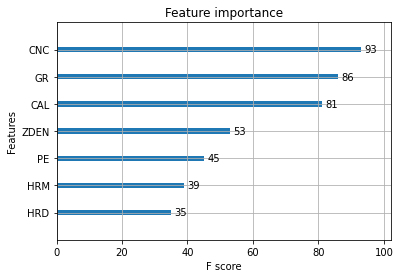

In [0]:
xgb.plot_importance(xgb_model_dtc)

#### <a>4.2.2 Model for DTS </a>

In [0]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [0]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

[03:14:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE_train:     5.311353118171967
RMSE_test:     9.355877806438809
R2_train:     0.9956638629838558
R2_test:     0.9870600142796958


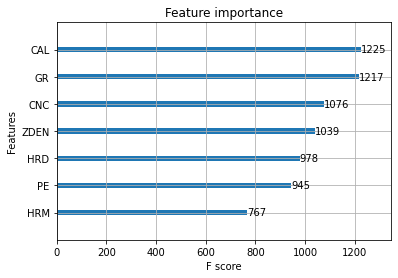

In [0]:
xgb.plot_importance(xgb_model_dts)

## <a>5. Model Predictions and Performance on Small Test Data</a>

#### Helper Function to plot the Results

In [0]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format(np.sqrt(mean_squared_error(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format(np.sqrt(mean_squared_error(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

### Data preparation for using Model
Apply the filters and transformation, which were applied on Training data.

In [0]:
# Replace value -999 ( missing value indicators ) as NA
dt.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
dt['CNC'][dt['CNC']<0] = np.nan
dt['GR'][dt['GR']<0] = np.nan
dt['PE'][dt['PE']<0] = np.nan
dt['ZDEN'][dt['ZDEN']<0] = np.nan
# Nullify the Outliers
dt['CNC'][dt['CNC']>0.7] = np.nan
dt['GR'][(dt['GR']>250)] = np.nan
dt['HRD'][dt['HRD']>200] = np.nan
dt['HRM'][dt['HRM']>200] = np.nan
# Log Transformation
dt['HRD'] = np.log(dt['HRD'])
dt['HRM'] = np.log(dt['HRM'])

In [0]:
dt_x = dt.drop(columns=['DTC','DTS'])

### Predict and Check the performance

In [0]:
# Separate the Actual/True Values of DTC and DTS
reals = np.array(dt.loc[:,['DTC','DTS']])

In [0]:
# Predict DTC and DTS using the trained models
dtc_predict = xgb_model_dtc.predict(dt_x)
dts_predict = xgb_model_dts.predict(dt_x)
preds_df = pd.DataFrame({'DTC':dtc_predict,'DTS':dts_predict})
preds = np.array(preds_df)

Combined Root Mean Square Error is: 16.26890
DTC: 3.95983
DTS: 22.66437


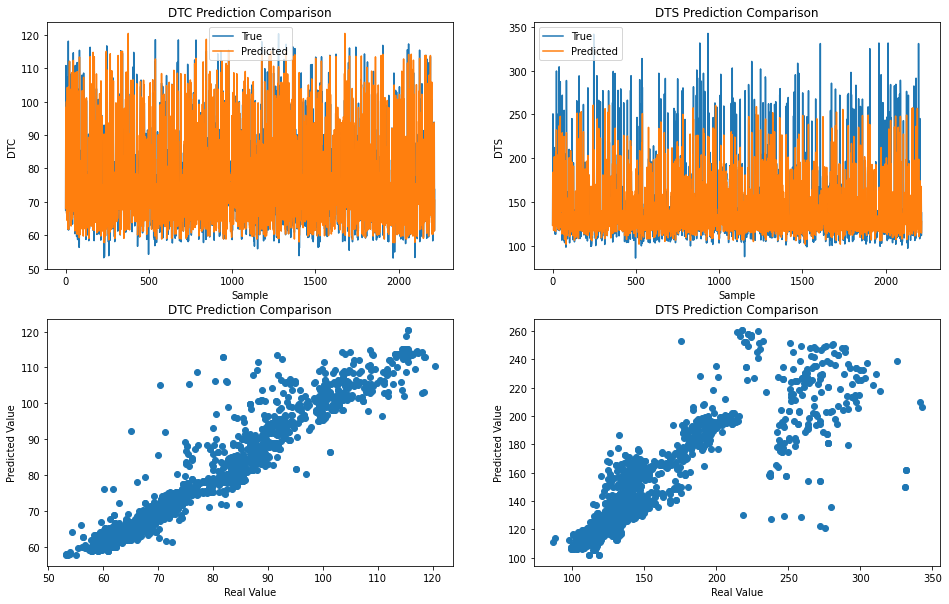

In [0]:
# Plot the Results and Print the Metrics
result_plot(preds,reals)

### Explaining the predictions

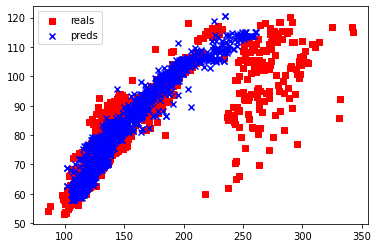

In [0]:
plt.scatter(dt['DTS'],dt['DTC'], c='r', marker='s', label='reals')
plt.scatter(preds_df['DTS'],preds_df['DTC'], c='b', marker='x', label='preds')
plt.legend(loc='upper left')
plt.show()

In [0]:
! pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=6cb409dd8e0bfb1be3c628e0387a6d52d3645ec248d002a429f1d863293c94fe
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgb_model_dts)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
shap_values = explainer.shap_values(dt_x)

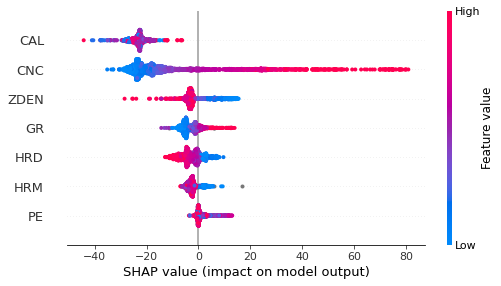

In [0]:
# summarize the effects of all the features
shap.summary_plot(shap_values, dt_x)

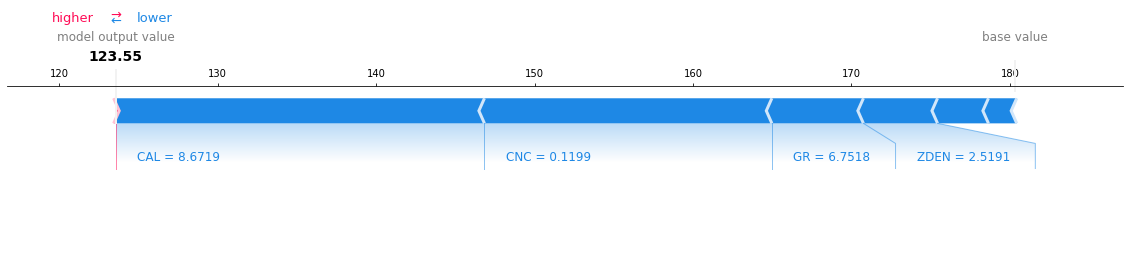

124.2332


In [0]:
i = 0
# visualize a specific prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value,shap_values[i,:], dt_x.iloc[i,:],matplotlib=True)
print(dt.iloc[i,:]['DTS'])

In [0]:
# Let's take some rows with True DTS values greater than 250 and check the explanation
high_dts_ix = dt.loc[dt['DTS']>250,:].index.to_list()

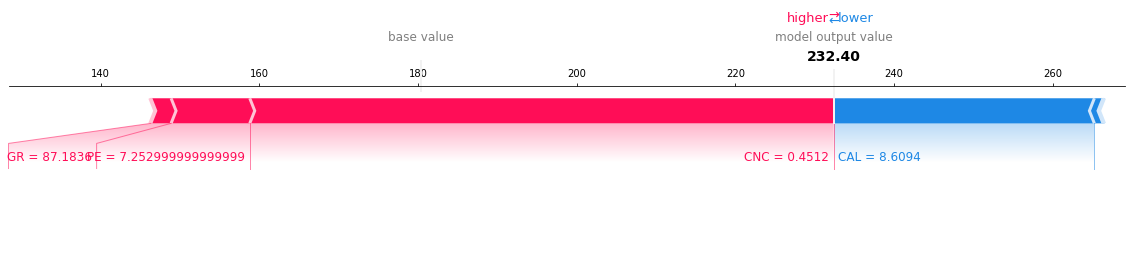

299.5884


In [0]:
i = high_dts_ix[1]
shap.force_plot(explainer.expected_value,shap_values[i,:], dt_x.iloc[i,:],matplotlib=True)
print(dt.iloc[i,:]['DTS'])

GR, PE and CNC are trying to push the value towards higher side, whereas CAL is pushing it towards lower side, hence final value ( predicted = 232 ) is much lower than the actual one ( 299 ).

## <a>6. Predictions on Test Data</a>

### Data preparation for using Model
Apply the filters and transformation, which were applied on Training data.

In [0]:
# Replace value -999 ( missing value indicators ) as NA
test.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
test['CNC'][test['CNC']<0] = np.nan
test['GR'][test['GR']<0] = np.nan
test['PE'][test['PE']<0] = np.nan
test['ZDEN'][test['ZDEN']<0] = np.nan
# Nullify the Outliers
test['CNC'][test['CNC']>0.7] = np.nan
test['GR'][(test['GR']>250)] = np.nan
test['HRD'][test['HRD']>200] = np.nan
test['HRM'][test['HRM']>200] = np.nan
# Log Transformation
test['HRD'] = np.log(test['HRD'])
test['HRM'] = np.log(test['HRM'])

In [0]:
test_x = test.copy()

### Predict DTC and DTS using the trained models

In [0]:
test['DTC'] = xgb_model_dtc.predict(test_x)
test['DTS'] = xgb_model_dts.predict(test_x)

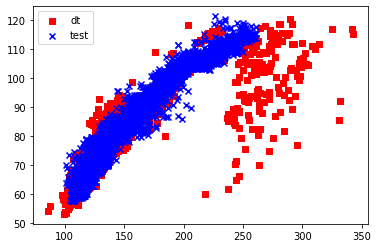

In [0]:
plt.scatter(dt['DTS'],dt['DTC'], c='r', marker='s', label='dt')
plt.scatter(test['DTS'],test['DTC'], c='b', marker='x', label='test')
plt.legend(loc='upper left')
plt.show()

Above plot shows that model is still struggling to predict High DTS values, i.e. greater than 250.

### Create the Submission File

In [0]:
test_submission = test.loc[:,['DTC','DTS']]
test_submission.head(5)

,DTC,DTS
0,105.394165,218.607941
1,107.486671,230.190521
2,107.650818,227.801239
3,107.812325,230.037674
4,105.404236,226.158859


In [0]:
test_submission.shape

(11088, 2)

In [0]:
test_submission.describe()

,DTC,DTS
count,11088.000000,11088.000000
mean,76.700737,141.313370
std,14.568948,32.575596
min,57.778740,100.834335
25%,65.511147,118.916220
50%,71.335892,129.082016
75%,85.508602,154.088364
max,121.295601,261.399200


In [0]:
test_submission.to_csv("Oilers_submission_2.csv", index = False)

## <a>7. Summary </a>

With using the simple XGboost Regression models to predict DTC and DTS, RMSE on the full test dataset with above models is 15.75537. ( as shown on Leaderboard ). Models are able to predict DTC quite closely. Also the DTS values upto 200, are predicted well, but model struggles to predict higher values.

Apart from the above models, we tried various approaches to improve the predictions, but couldn't get a drastic improvement in Final RMSE :

*   Various Missing value imputation approaches, e.g.:sklearn's IterativeImputer, AutoImpute library
*   Outliers treatment methods : Isolation Forest, z-score, custom range filters etc.
*   Feature engineering : Clustering & dimensionality reduction, Pass DTC as a feature for DTS prediction, separate models for Low and High Value clusters of DTS etc.
*   Different scalers - Standard, MinMax & Robust scalers
*   Passing Covariate shift information to the Model as Sample weights, Dropping the features causing covariate shift e.g. CAL, PE etc.
*   Since Targets DTC and DTS are skewed, we also tried TransformedTargetRegressor to see if that improves the predictions or not.

We also tried different models like Random Forest, LightGBM, ANN but couldn't spend much time on Hyperparamter tuning. XGboost with minimal hyperparameter tuning came out as the model with best RMSE.
Also, didn't do much on Feature engineering, which can help in improving the predictions. Properly tuned Neural Network models could have improved RMSE as they can learn/create complex features.



















